# 3. 개선된 평가 및 시각화 (Advanced Evaluation & Analysis) - 샘플링X 후처리X
- 데이터 특성(Domain)에 따른 성능 변화 분석
- 문서 길이, 문장 복잡도, 쿼리 복잡도에 따른 Segmented Evaluation

In [6]:
import json
import pickle
import os
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from tqdm.notebook import tqdm
from kiwipiepy import Kiwi

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

PROJECT_ROOT = Path('..').resolve()
DATA_DIR = PROJECT_ROOT / 'data'
RESULTS_DIR = PROJECT_ROOT / 'results'
ANALYSIS_DIR = PROJECT_ROOT / 'analysis'

os.makedirs(ANALYSIS_DIR, exist_ok=True)

print("데이터 로드 중")

# 데이터 로드
with open(RESULTS_DIR / 'search_results.json', 'r', encoding='utf-8') as f:
    search_results = json.load(f)
with open(DATA_DIR / 'qrels.pkl', 'rb') as f:
    qrels_list = pickle.load(f)
with open(DATA_DIR / 'queries.pkl', 'rb') as f:
    queries_data = pickle.load(f)
with open(DATA_DIR / 'corpus.pkl', 'rb') as f:
    corpus_data = pickle.load(f)

# 매핑 생성
qrels = defaultdict(set)
for q in qrels_list:
    qrels[q['query-id']].add(q['corpus-id'])

query_map = {q['_id']: q['text'] for q in queries_data}
corpus_map = {doc['_id']: doc['text'] for doc in corpus_data}

print(f"로드 완료: 문서 {len(corpus_map):,}개, 검색 결과 {len(search_results):,}개")

데이터 로드 중
로드 완료: 문서 50,222개, 검색 결과 1,453개


## 3-1. 문서 특성 정밀 분석 (Feature Extraction with KSS)

In [7]:
kiwi = Kiwi(num_workers=-1)
print("\nKiwi 기반 문서 특성 분석")

doc_stats = {}
conn = sqlite3.connect(str(PROJECT_ROOT / 'database/inverted_index.db'))
cursor = conn.cursor()

def analyze_advanced_features(text):
    # 1. 음절 수 (Syllables)
    syllables = len(text.replace(" ", ""))

    # 2. 문장 분리 (KSS)
    try:
        sentences = kiwi.split_into_sents(text)
        sentence_count = len(sentences)
    except:
        sentences = text.split('.') # Fallback
        sentence_count = len(sentences)

    # 3. 문장 복잡도 (Average Sentence Length)
    # 문장이 길수록(음절이 많을수록) 복잡한 구조일 가능성이 높음
    avg_sent_len = syllables / sentence_count if sentence_count > 0 else 0

    return avg_sent_len

# 전체 문서 분석
for doc_id, text in tqdm(corpus_map.items(), desc="Analyzing Corpus"):
    # DB에서 형태소 개수(Morph Count) 가져오기
    cursor.execute("SELECT length FROM documents WHERE doc_id = ?", (doc_id,))
    res = cursor.fetchone()
    morph_count = res[0] if res else 0

    # kiwi 분석
    avg_len = analyze_advanced_features(text)

    doc_stats[doc_id] = {
        'morph_count': morph_count,   # 길이 도메인
        'avg_sent_len': avg_len       # 복잡도 도메인
    }

conn.close()


Kiwi 기반 문서 특성 분석


Analyzing Corpus:   0%|          | 0/50222 [00:00<?, ?it/s]

## 3-2. 도메인별 성능 분석 함수 (Segmented Evaluator)

In [8]:
def evaluate_by_segment(metric_key, labels=['Low', 'Mid', 'High']):
    # 구간 기준 설정 (3분위수 Quantile)
    all_values = [stats[metric_key] for stats in doc_stats.values()]
    thresholds = np.quantile(all_values, [1/3, 2/3])

    print(f"[{metric_key}] 구간 기준: ~{thresholds[0]:.1f} / ~{thresholds[1]:.1f} / ~Max")

    segment_scores = defaultdict(lambda: {'bim_hits': 0, 'bm25_hits': 0, 'total': 0})

    for qid, relevant in qrels.items():
        query_res = next((r for r in search_results if r['query_id'] == qid), None)
        if not query_res: continue

        bm25_top10 = {r['doc_id'] for r in query_res['results'][:10]}
        bim_sorted = sorted(query_res['results'], key=lambda x: x['bim_score'], reverse=True)[:10]
        bim_top10 = {r['doc_id'] for r in bim_sorted}

        for doc_id in relevant:
            if doc_id not in doc_stats: continue
            val = doc_stats[doc_id][metric_key]

            # 그룹 할당
            if val <= thresholds[0]: group = labels[0]
            elif val <= thresholds[1]: group = labels[1]
            else: group = labels[2]

            segment_scores[group]['total'] += 1
            if doc_id in bim_top10: segment_scores[group]['bim_hits'] += 1
            if doc_id in bm25_top10: segment_scores[group]['bm25_hits'] += 1

    # 결과 집계
    results = {}
    for group in labels:
        total = segment_scores[group]['total']
        if total == 0: continue
        results[group] = {
            'BIM': segment_scores[group]['bim_hits'] / total,
            'BM25': segment_scores[group]['bm25_hits'] / total
        }
    return results

## 3-3. 쿼리 복잡도 분석 함수 (Query Domain Analysis)

In [9]:
def analyze_query_domain():
    print("\n쿼리 길이에 따른 성능 변화 분석")
    group_stats = {
        'Keyword (Short)': {'bim': 0, 'bm25': 0, 'cnt': 0},
        'Verbose (Long)':  {'bim': 0, 'bm25': 0, 'cnt': 0}
    }

    for qid, relevant in qrels.items():
        if qid not in query_map: continue

        # 쿼리 길이 (공백 기준 단어 수)
        q_len = len(query_map[qid].split())
        group = 'Keyword (Short)' if q_len <= 2 else 'Verbose (Long)'

        query_res = next((r for r in search_results if r['query_id'] == qid), None)
        if not query_res: continue

        bm25_top10 = {r['doc_id'] for r in query_res['results'][:10]}
        bim_sorted = sorted(query_res['results'], key=lambda x: x['bim_score'], reverse=True)[:10]
        bim_top10 = {r['doc_id'] for r in bim_sorted}

        # 해당 쿼리의 P@10 계산
        p10_bim = len([d for d in bim_top10 if d in relevant]) / 10
        p10_bm25 = len([d for d in bm25_top10 if d in relevant]) / 10

        group_stats[group]['bim'] += p10_bim
        group_stats[group]['bm25'] += p10_bm25
        group_stats[group]['cnt'] += 1

    results = {}
    for g, s in group_stats.items():
        if s['cnt'] == 0: continue
        results[g] = {'BIM': s['bim']/s['cnt'], 'BM25': s['bm25']/s['cnt']}
    return results

## 3-4. 실행 및 시각화

[morph_count] 구간 기준: ~333.0 / ~1088.0 / ~Max


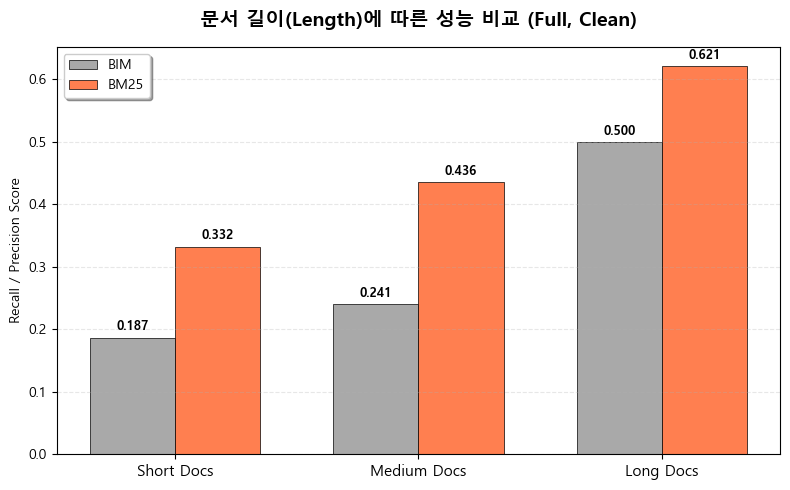

[avg_sent_len] 구간 기준: ~41.6 / ~50.6 / ~Max


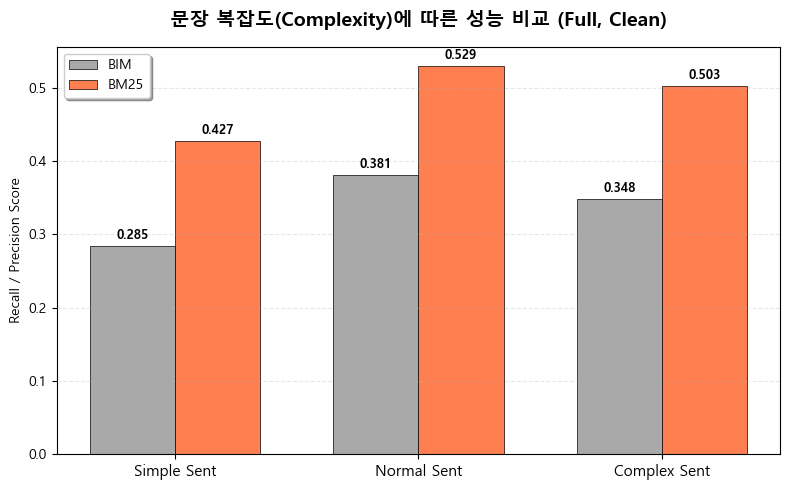


쿼리 길이에 따른 성능 변화 분석


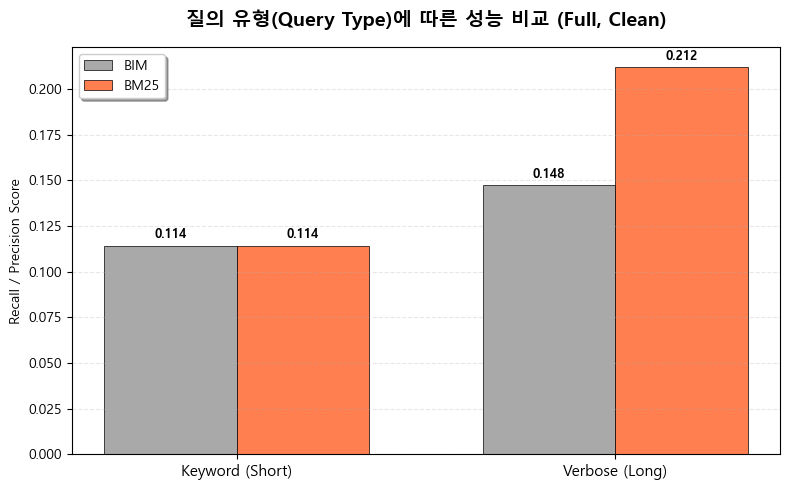

In [10]:
def plot_analysis(results, title, filename):
    groups = list(results.keys())
    bim_vals = [results[g]['BIM'] for g in groups]
    bm25_vals = [results[g]['BM25'] for g in groups]

    x = np.arange(len(groups))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))


    rects1 = ax.bar(x - width/2, bim_vals, width, label='BIM', color='#A9A9A9', edgecolor='black', linewidth=0.5)
    rects2 = ax.bar(x + width/2, bm25_vals, width, label='BM25', color='#FF7F50', edgecolor='black', linewidth=0.5)

    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_ylabel('Recall / Precision Score', fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels(groups, fontsize=11)
    ax.legend(frameon=True, fancybox=True, shadow=True)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # 값 표시 (Annotation)
    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig(ANALYSIS_DIR / filename, dpi=300)
    plt.show()

# 문서 길이 도메인
res_len = evaluate_by_segment('morph_count', labels=['Short Docs', 'Medium Docs', 'Long Docs'])
plot_analysis(res_len, "문서 길이(Length)에 따른 성능 비교 (Full, Clean)", "advanced_analysis_length_full_dirty.png")

# 문장 복잡도 도메인
res_complex = evaluate_by_segment('avg_sent_len', labels=['Simple Sent', 'Normal Sent', 'Complex Sent'])
plot_analysis(res_complex, "문장 복잡도(Complexity)에 따른 성능 비교 (Full, Clean)", "advanced_analysis_complexity_full_dirty.png")

# 쿼리 복잡도 도메인
res_query = analyze_query_domain()
plot_analysis(res_query, "질의 유형(Query Type)에 따른 성능 비교 (Full, Clean)", "advanced_analysis_query_full_dirty.png")